# Introduction
Determin Porygon DT of Sampled Users to Each Vendor


# Data collection
We get the data from big query.

In [ ]:
%%capture
# install packages
!pip install folium
!pip install geopandas

In [ ]:
# load packages
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import TimestampedGeoJson
from folium import plugins
from folium.plugins import HeatMap
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
import geopandas
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
from shapely import wkt
%matplotlib inline
from google.colab import drive # to allow colab save file in my drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

Mounted at /content/drive
Authenticated
The google.colab.data_table extension is not loaded.


In [ ]:
# Define working directory
%cd "/content/drive/Shared drives/Global Pricing/2 - Entities/LATAM/Peya + Domicilios + Appetito24/BO Peya"
%pwd
%ls

/content/drive/Shared drives/Global Pricing/2 - Entities/LATAM/Peya + Domicilios + Appetito24/BO Peya
 13_agg.csv
 13_avg.csv
'1. VW Study'/
'2. Customer Research Surveys'/
'3. DPS migration'/
'4. AB Testing'/
'BO penetration matrix.twbx'
'BO - Recommendations for optimizing growth.gslides'
'BO_T1_2 - Change in free delivery_CAHE.pptx'
'Conversion by Zone in all countries.twbx'
'Conversion by Zone in BO.twbx'
'MOV analysis TW.xlsx'
'MOV Unit Economics analysis BO.xlsx'


## Create temp tables

First you need to define in which country, which city and which vehicle_profile_tbd you want it to run. 

Second, you run the query to create table

Third, you request the table data as a data frame.

In [ ]:
# define some variables
project_id = "fulfillment-dwh-production"
entity_id = "PY_BO" 
country_code = "bo"
vehicle_profile = "scooter_v1"
geohash_digit = "6"
city_id = 1

# define project id
client = bigquery.Client(project = project_id)

print("This script will return price points result in a table for {a} as vehicle profile with {b}-digit geohash in City {c} of entity {d}".format(a=vehicle_profile, b=geohash_digit, c=city_id, d=entity_id))

This script will return price points result in a table for scooter_v1 as vehicle profile with 6-digit geohash in City 1 of entity PY_BO


In [ ]:
# Bigquery script to create temp tables
# Create temp tables 
query = """
-- zone_table to get basic zone and shape info
drop table if exists `temp.zone_""" + entity_id + """`;
create table `temp.zone_""" + entity_id + """`
options (
  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
) as (
	
	select p.entity_id
    , country_code
    , ci.name AS city_name
    , ci.id AS city_id
    , st_astext(zo.shape) AS zone_shape 
    , zo.name AS zone_name
    , zo.id AS zone_id
  from cl.countries co
  left join unnest(co.platforms) p
  left join unnest(co.cities) ci
  left join unnest(ci.zones) zo
  where entity_id = \"""" + entity_id + """\"
		and co.country_code = \"""" + country_code + """\" 
		and ci.is_active
		and zo.id is not null
		and zo.is_active
		and lower(zo.name) not like 'dmart%'
  group by 1,2,3,4,5,6,7);

-- vendor table to get location info and zone_id of active vendors
drop table if exists `temp.res_temp_""" + entity_id + """`;
CREATE TABLE `temp.res_temp_""" + entity_id + """`
OPTIONS(
  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
) as (
	select
		v.entity_id,
		v.vertical_type,
		z.country_code,
		lo.city_id,
		lo.city_name,
		zone_name,
		zone_id,
		v.vendor_code,
		st_x(v.location) as res_long,
		st_y(v.location) as res_lat,
		lower(to_json_string(p.delivery_provider)) as delivery_provider,
		max(h.drive_time) as max_dt
	from cl.vendors_v2 v
	left join unnest(delivery_areas) d
	left join unnest(history) h
	left join unnest(porygon) p
	left join unnest(delivery_areas_location) lo
	inner join temp.zone_""" + entity_id + """ z
		on v.entity_id = z.entity_id
		and lo.city_id = z.city_id
	where v.entity_id = \"""" + entity_id + """\" 
	and st_contains(st_geogfromtext(z.zone_shape), v.location)
	and h.active_to is null
	and d.is_deleted = false
	and v.is_active 
	group by 1,2,3,4,5,6,7,8,9,10,11);

-- porygon_temp table to have up to date porygon area
drop table if exists `temp.porygon_temp_""" + country_code + """`;
create table `temp.porygon_temp_""" + country_code + """`
options (
  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
) as (
	select
		a.restaurant_id,
		a.time,
		a.country_code,
		a.shape_wkt
	from dl.porygon_drive_time_polygons a
	inner join
		(select
			restaurant_id,
			time,
			country_code,
			vehicle_profile,
			max(updated_at) as updated_at
		from dl.porygon_drive_time_polygons
		where vehicle_profile = \"""" + vehicle_profile + """\" 
    and country_code = \"""" + country_code + """\" 
		group by 1,2,3,4) b
	on a.restaurant_id = b.restaurant_id
		and a.country_code = b.country_code
		and a.updated_at = b.updated_at
	group by 1,2,3,4);


-- add porygon info to active vendors
drop table if exists `temp.res_""" + entity_id + """`;
create table `temp.res_""" + entity_id + """`
options (
  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
) as (
	select
		r.vendor_code
		, r.vertical_type
		, r.country_code
		, r.entity_id
		, r.city_id
		, r.city_name
		, r.zone_id
		, r.zone_name
		, res_long
		, res_lat
		, max_dt
		, delivery_provider
		, p.time as porygon_dt
		, p.shape_wkt
	from temp.porygon_temp_""" + country_code + """ p
	inner join temp.res_temp_""" + entity_id + """ r
		on p.restaurant_id = r.vendor_code and lower(p.country_code) = lower(r.country_code));


drop table if exists `temp.user_geohash_""" + entity_id + """`;
create table `temp.user_geohash_""" + entity_id + """`
options (
  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
) as (
	select
		st_geohash(st_geogpoint(content.delivery.location.longitude, content.delivery.location.latitude ),""" + geohash_digit + """) as geohash
		, zo.zone_id
		, count(distinct content.order_id) order_count
		, count(distinct content.customer.customer_id) user_count
	from dl.data_fridge_order_stream o
	inner join temp.zone_""" + entity_id + """ zo
		on o.global_entity_id = zo.entity_id
	where o.global_entity_id = \"""" + entity_id + """\" 
		and created_date between current_date() - 28 and current_date() - 1
		and st_contains(st_geogfromtext(zone_shape), st_geogpointfromgeohash(st_geohash(st_geogpoint(content.delivery.location.longitude, content.delivery.location.latitude ),""" + geohash_digit + """)))
	group by 1,2);

drop table if exists `temp.first_match_""" + entity_id + """`;
create table `temp.first_match_""" + entity_id + """`
options (
	  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
	) as (
	select
		r.vendor_code
		, r.vertical_type
		, r.country_code
		, r. entity_id
		, r.city_id
		, r.city_name
		, r.zone_id
		, r.zone_name
		, res_long
		, res_lat
		, max_dt
		, delivery_provider
		, u.geohash
		, u.order_count
		, u.user_count
		, porygon_dt
	from temp.user_geohash_""" + entity_id + """ u
	cross join temp.res_""" + entity_id + """ r
	where u.zone_id = r.zone_id 
	--and st_within(st_geogpointfromgeohash(u.geohash), safe.st_geogfromtext(r.delivery_area))
  and st_within(st_geogpointfromgeohash(u.geohash), safe.st_geogfromtext(r.shape_wkt))
  group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
 );

drop table if exists `temp.results_""" + entity_id + """`;
create table `temp.results_""" + entity_id + """`
	options (
	  expiration_timestamp = timestamp_add(current_timestamp(), interval 30 day)
	) as (
select
	f.zone_id,
	f.zone_name,
	zone_shape,
	vendor_code,
	vertical_type,
	res_long,
	res_lat,
	max_dt,
	delivery_provider,
	geohash,
	st_astext(st_geogpointfromgeohash(geohash)) as geohash_center,
	avg(order_count) as order_weight,
	avg(user_count) as user_weight,
	min(porygon_dt) as porygon_dt
from temp.first_match_""" + entity_id + """ f
left join temp.zone_""" + entity_id + """ zo on zo.zone_id = f.zone_id
group by 1,2,3,4,5,6,7,8,9,10,11)
"""

query_job = client.query(query).to_dataframe()  # Make an API request.


In [ ]:
query2 = """
select
    zone_id,
	  zone_name,
	  zone_shape,
	  vendor_code,
	  vertical_type,
	  res_long,
	  res_lat,
	  geohash,
	  order_weight,
	  user_weight,
		delivery_provider,
	  porygon_dt,
		max_dt,
    st_x(st_geogfromtext(geohash_center)) as long,
    st_y(st_geogfromtext(geohash_center)) as lat
  from `temp.results_""" + entity_id + """` r
    """

df = client.query(query2).to_dataframe()
df.head()

,zone_id,zone_name,zone_shape,vendor_code,vertical_type,res_long,res_lat,geohash,order_weight,user_weight,delivery_provider,porygon_dt,max_dt,long,lat
0,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",89447,restaurants,-63.210201,-17.813299,6sg4cs,1946.0,682.0,"[""own_delivery""]",17,NaN,-63.209839,-17.773132
1,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",111713,restaurants,-63.184299,-17.784000,6sg4fe,3443.0,1164.0,"[""own_delivery""]",12,5.0,-63.165894,-17.778625
2,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",63878,restaurants,-63.169399,-17.735399,6sg562,261.0,99.0,"[""own_delivery""]",18,NaN,-63.176880,-17.707214
3,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",68664,restaurants,-63.164700,-17.725599,6sg57j,876.0,322.0,"[""own_delivery""]",14,NaN,-63.143921,-17.679749
4,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",175398,restaurants,-63.157200,-17.722200,6sg55h,320.0,149.0,"[""own_delivery""]",10,NaN,-63.143921,-17.729187


##  Clean data

In [ ]:
df["delivery_type"] = df["delivery_provider"]
df['delivery_type'] = pd.np.where(df.delivery_provider.str.contains("own"), "own_delivery",
                   pd.np.where(df.delivery_provider.str.contains("vendor"), "vendor_delivery",
                   "other"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [ ]:
# delete certain geohash and vendor combination, when porygon drive time is bigger than max drive time of MP vendors
#df = df.fillna(0)
df["porygon_dt_new"] = df["porygon_dt"]
#df.loc[(df.delivery_type == "vendor_delivery") & (df.porygon_dt > df.max_dt) , 'porygon_dt_new'] = "delete"
df = df.loc[df["porygon_dt_new"] != "delete"]
df.head()

,zone_id,zone_name,zone_shape,vendor_code,vertical_type,res_long,res_lat,geohash,order_weight,user_weight,delivery_provider,porygon_dt,max_dt,long,lat,delivery_type,porygon_dt_new
0,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",89447,restaurants,-63.210201,-17.813299,6sg4cs,1946.0,682.0,"[""own_delivery""]",17,NaN,-63.209839,-17.773132,own_delivery,17
1,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",111713,restaurants,-63.184299,-17.784000,6sg4fe,3443.0,1164.0,"[""own_delivery""]",12,5.0,-63.165894,-17.778625,own_delivery,12
2,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",63878,restaurants,-63.169399,-17.735399,6sg562,261.0,99.0,"[""own_delivery""]",18,NaN,-63.176880,-17.707214,own_delivery,18
3,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",68664,restaurants,-63.164700,-17.725599,6sg57j,876.0,322.0,"[""own_delivery""]",14,NaN,-63.143921,-17.679749,own_delivery,14
4,1,Santa cruz,"POLYGON((-63.162816055119 -17.6949118330478, -...",175398,restaurants,-63.157200,-17.722200,6sg55h,320.0,149.0,"[""own_delivery""]",10,NaN,-63.143921,-17.729187,own_delivery,10


## Define vertical types you are interested in

In [ ]:
# which vertical types vendors have 
vertical = df.vertical_type.unique()
vertical = vertical.tolist()
vertical

['restaurants',
 'pharmacies',
 'coffee',
 'courier_business',
 'cross_vertical',
 'groceries',
 'drinks',
 'pets',
 'courier',
 'darkstores']

In [ ]:
# define the zone you want to choose
vertical = ["restaurants"]
df_vert = df[df["vertical_type"].isin(vertical)]

# Option A: Whole city

In [ ]:
df_nodup = df_vert[["vendor_code","vertical_type", "res_long", "res_lat", "geohash", "order_weight", "user_weight", "porygon_dt", "long", "lat", "delivery_type"]]
df_nodup = df_nodup.drop_duplicates()
pivot=df_nodup.pivot_table("vendor_code", index=["geohash","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
geohash,user_weight,,,,,,,,,,,,,,,,,,,,
6mp9bs,26.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,11.0,17.0,27.0,38.0,53.0,68.0,74.0,90.0,98.0,102.0,102.0,102.0,102.0
6mp9bu,26.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,6.0,11.0,20.0,34.0,53.0,67.0,88.0,90.0,92.0,92.0,92.0,92.0,100.0
6mp9bv,57.0,0.0,1.0,2.0,3.0,4.0,8.0,13.0,23.0,36.0,50.0,67.0,76.0,87.0,92.0,92.0,92.0,93.0,95.0,100.0,101.0
6mp9by,109.0,0.0,0.0,0.0,1.0,8.0,13.0,33.0,44.0,53.0,81.0,89.0,92.0,92.0,92.0,92.0,92.0,98.0,102.0,102.0,102.0
6mp9bz,83.0,0.0,0.0,0.0,0.0,2.0,14.0,28.0,47.0,73.0,82.0,90.0,91.0,92.0,93.0,101.0,101.0,102.0,102.0,102.0,102.0


## Insight 1: Share of Customers seeing free delivery vendors depending on the first tier size

Text(249.0, 0.5, 'Number of Vendors')

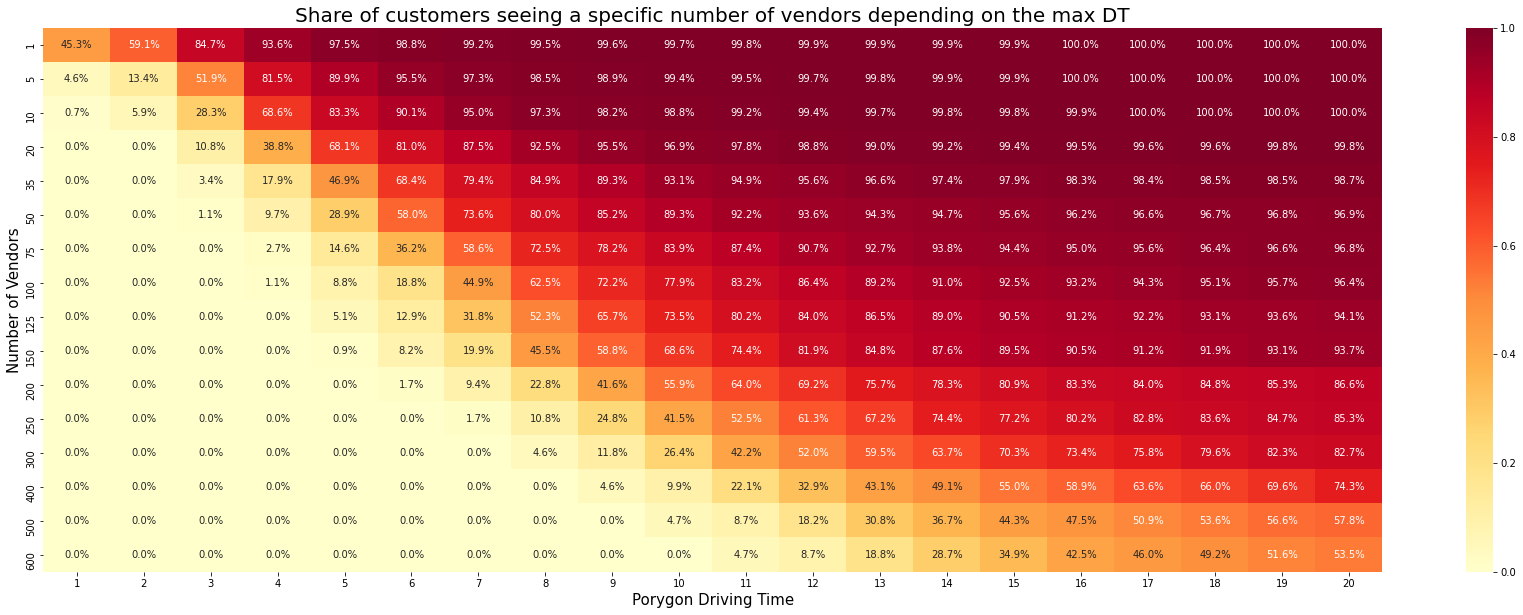

In [ ]:
weight = pivot_cumsum.reset_index()

numOfVendors = [1, 5, 10, 20, 35, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600]
drivingTimesinMin = range(1,df_nodup["porygon_dt"].max()+1)
resArray = []
for indexNumOfVendors in numOfVendors:
    sumByDrivingTimes = []
    for indexDrivingTimesInMin in drivingTimesinMin:
        sumByDrivingTimes.append(weight.loc[weight[indexDrivingTimesInMin] >= indexNumOfVendors, "user_weight"].sum())
        
    sumByDrivingTimes.insert(0,indexNumOfVendors)
    resArray.append(sumByDrivingTimes)

resArray

colNames = np.append("Number of Vendors", drivingTimesinMin)

df2 = pd.DataFrame(resArray,
                   columns = colNames)
df2=df2.set_index('Number of Vendors')
col_list = list(df2)
totalnum = weight["user_weight"].sum()
df2=df2[col_list].div(totalnum)
#df2=df2.reset_index()
df2

# Visualization
plt.subplots(figsize=(30,10))
sns.heatmap(df2, fmt=".1%", annot=True, cmap='YlOrRd')
plt.title('Share of customers seeing a specific number of vendors depending on the max DT', fontsize = 20)

plt.xlabel('Porygon Driving Time', fontsize = 15)
plt.ylabel('Number of Vendors', fontsize = 15)

## Insight 2: The marginal effect of expanding porygon driving time areas


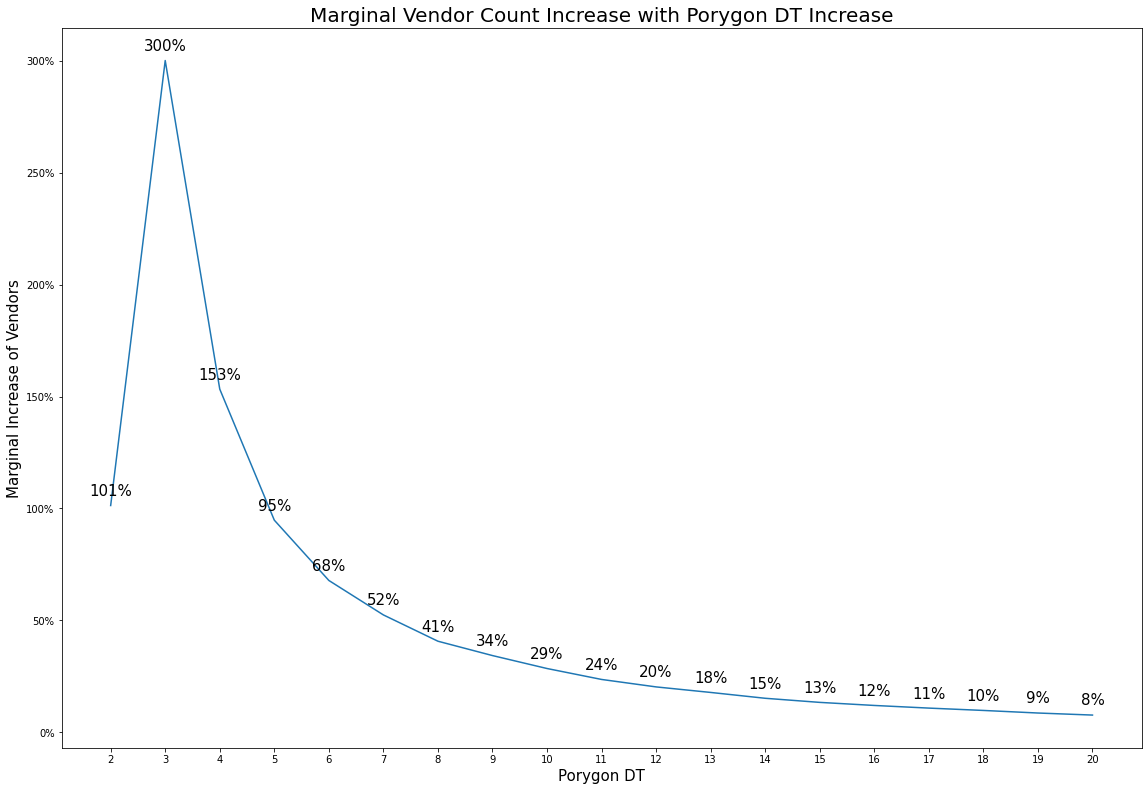

In [ ]:
pivot_cumsum.head()
pory_margin = pivot_cumsum.mean()
pory_margin = pd.DataFrame(pory_margin, columns = ["vendors"])

row = list(pory_margin.index.values)
row = row[1:]
count_a_vals = pory_margin['vendors'].values
delta = (count_a_vals[1:] - count_a_vals[:-1])/count_a_vals[:-1]

delta = pd.DataFrame(delta, columns = ["Marginal Increase of Vendor Count"])
delta["Increase to Porygon DT"] = row
delta

#Marginal Vendor Count Increase with Porygon DT increase
fig = plt.figure()
xs = delta["Increase to Porygon DT"]
ys = delta["Marginal Increase of Vendor Count"]
axes = fig.add_axes([0.1, 0.1, 2.5, 2.5])
axes.plot(xs, ys)
for x,y in zip(xs,ys):
    label = "{:.0f}%".format(y*100)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 15) # horizontal alignment can be left, right or center

axes.set_xlabel('Porygon DT', fontsize = 15)
axes.set_ylabel('Marginal Increase of Vendors', fontsize = 15)
axes.set_title('Marginal Vendor Count Increase with Porygon DT Increase', fontsize = 20)
axes.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
axes.set_xticks(delta['Increase to Porygon DT'])

plt.show()

In [ ]:
#pory_margin = pivot_cumsum.mean()
#pory_margin = pd.DataFrame(round(pory_margin,1), columns = ["vendor_amount"]).reset_index()
pivot=df_nodup.pivot_table("vendor_code", index=["geohash","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_sum = pivot.cumsum(axis=1).reset_index()
melt = pd.melt(pivot_sum, id_vars=["geohash","user_weight"], value_vars=df.porygon_dt.unique().tolist())
melt["weighted_value"] = melt["value"] * melt["user_weight"] 
geohash = melt[["geohash",'user_weight']].drop_duplicates()
agg = pd.pivot_table(melt,values = ["geohash","value", "weighted_value"], index=["porygon_dt"], 
                     aggfunc = {"value":"sum", "geohash":"count", "weighted_value":"sum"}).reset_index()

agg["avg"] = (agg["value"]/len(melt.geohash.unique())).round(1)
agg['weighted_avg'] = (agg["weighted_value"]/(geohash["user_weight"].sum())).round(1)
agg.head()

,porygon_dt,geohash,value,weighted_value,avg,weighted_avg
0,1,602,226.0,173148.0,0.4,1.1
1,2,602,455.0,313549.0,0.8,2.0
2,3,602,1820.0,1259399.0,3.0,8.2
3,4,602,4610.0,3210359.0,7.7,20.8
4,5,602,8980.0,6187965.0,14.9,40.1


In [ ]:
fig = px.bar(agg, x='porygon_dt', y='avg', 
             text = "avg",
             title = "Average vendor amount user location see accroding to porygon drive time",
             labels = {
                 "porygon_dt": "Porygon Drive Time",
                 "avg": "Unweighted vendor Amount"
             })

fig.update_xaxes(type='category')
fig.show()

In [ ]:
fig = px.bar(agg, x='porygon_dt', y='weighted_avg', 
             text = "weighted_avg",
             title = "Average vendor amount users see accroding to porygon drive time",
             labels = {
                 "porygon_dt": "Porygon Drive Time",
                 "avg": "Vendor Amount"
             })
fig.update_xaxes(type='category')
fig.show()

In [ ]:
pivot=df_nodup.pivot_table("vendor_code", index=["geohash","delivery_type","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1).reset_index()
melt = pd.melt(pivot_cumsum, id_vars=["geohash","delivery_type", "user_weight"], value_vars=df.porygon_dt.unique().tolist())
melt["weighted_value"] = melt["value"] * melt["user_weight"] 
melt.head()

avg = pd.pivot_table(melt,values = ["geohash","value", "weighted_value"], index=["porygon_dt","delivery_type"], 
                     aggfunc = {"value":"sum", "geohash":"count", "weighted_value":"sum"}).reset_index()

avg["avg"] = (avg["value"]/len(melt.geohash.unique())).round(1)
avg['weighted_avg'] = (avg["weighted_value"]/(geohash["user_weight"].sum())).round(1)
avg.head()

,porygon_dt,delivery_type,geohash,value,weighted_value,avg,weighted_avg
0,1,own_delivery,602,225.0,172713.0,0.4,1.1
1,1,vendor_delivery,60,1.0,435.0,0.0,0.0
2,2,own_delivery,602,454.0,313114.0,0.8,2.0
3,2,vendor_delivery,60,1.0,435.0,0.0,0.0
4,3,own_delivery,602,1819.0,1258964.0,3.0,8.2


In [ ]:
fig = px.bar(avg, x='porygon_dt', y='weighted_avg', color="delivery_type",
             text = "weighted_avg",
             title = "Average vendor amount users see accroding to porygon drive time",
             labels = {
                 "porygon_dt": "Porygon Drive Time",
                 "weighted_avg": "Weighted average vendor amount"
             })
fig.update_xaxes(type='category')
fig.show()

## Insight 3: Map Visualization

In [ ]:
# get zone shape for whole city
city_geo = df[["zone_name", "zone_shape"]]
city_geo = city_geo.drop_duplicates()
city_geo["zone_shape"] = city_geo["zone_shape"].apply(wkt.loads)

# get user geohash and how many vendors they could see
df_city = pd.pivot_table(df_nodup, values = ["vendor_code", "order_weight", "user_weight"], index=["geohash", "long", "lat"], 
                           aggfunc={"vendor_code": 'count', "order_weight": "mean", "user_weight": "mean"}).reset_index()

# get vendors info
res_city = df[["vendor_code","res_lat","res_long", "vertical_type"]].drop_duplicates()

In [ ]:
# vendors layer
from folium.plugins import HeatMap
def generateBaseMap(default_location=[df_city["lat"].mean(), df_city["long"].mean()], default_zoom_start=13):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()
res_loc = res_city[["res_lat","res_long"]].values.tolist()
HeatMap(data = res_loc, radius=8, max_zoom=13).add_to(base_map)

# add tiles to map
folium.raster_layers.TileLayer('Open Street Map').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(base_map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(base_map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(base_map)

# add layer "zone shape" to map
style = {'fillColor': 'none', 'lineColor': 'grey'}
city_geo.apply(lambda row:folium.GeoJson(row["zone_shape"], name="zone_name",style_function=lambda x: style).add_to(base_map), axis=1)

# user geohash layer
df_city.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=row["order_weight"]/df_city.order_weight.median(),
                                              popup="Daily order amount: {},    Vendor amount: {}".format(round(row["order_weight"]/28,1), row["vendor_code"]),
                                              color='red')
                                              .add_to(base_map), axis=1)


# display map
base_map

# Option B: Only one Zone

In [ ]:
# if you want to have 
zone_id = df_vert.zone_id.unique()
zone_id = zone_id.tolist()
zone_id

[1, 2, 15, 14, 17, 13, 3, 9, 5, 11, 16]

**IMPORTANT:** about choosing zones!

If you want to choose all zones, then you need to do nothing
If you want to choose one zone or more thatn one zones, then remove the "#" and put the zone_ids in the branket and run the script 

In [ ]:
# define the zone you want to choose
zone_id = [1]
df_zone = df_vert[df_vert["zone_id"].isin(zone_id)]

pivot=df_zone.pivot_table("vendor_code", index=["geohash","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

,porygon_dt,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
geohash,user_weight,,,,,,,,,,,,,,,,,,,,
6sg46r,66.0,0.0,0.0,0.0,2.0,4.0,6.0,7.0,12.0,13.0,26.0,41.0,61.0,83.0,111.0,150.0,206.0,247.0,286.0,329.0,371.0
6sg492,27.0,0.0,0.0,0.0,1.0,4.0,9.0,12.0,18.0,30.0,52.0,74.0,100.0,119.0,147.0,191.0,238.0,288.0,342.0,384.0,421.0
6sg493,126.0,0.0,0.0,0.0,1.0,11.0,15.0,26.0,41.0,55.0,81.0,105.0,131.0,172.0,214.0,262.0,317.0,373.0,411.0,487.0,573.0
6sg494,143.0,0.0,1.0,7.0,12.0,19.0,34.0,50.0,60.0,86.0,119.0,138.0,171.0,225.0,272.0,334.0,386.0,433.0,533.0,600.0,670.0
6sg495,198.0,0.0,0.0,2.0,7.0,12.0,19.0,34.0,51.0,62.0,86.0,114.0,134.0,168.0,215.0,260.0,323.0,372.0,431.0,516.0,608.0


In [ ]:
# define the zone you want to choose
zone_id = [7]
df_zone = df_vert[df_vert["zone_id"].isin(zone_id)]

pivot=df_zone.pivot_table("vendor_code", index=["geohash","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

pivot=df_zone.pivot_table("vendor_code", index=["geohash","delivery_type","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1).reset_index()
melt = pd.melt(pivot_cumsum, id_vars=["geohash","delivery_type", "user_weight"], value_vars=df_zone.porygon_dt.unique().tolist())
melt["weighted_value"] = melt["value"] * melt["user_weight"] 
melt.head()

avg = pd.pivot_table(melt,values = ["geohash","value", "weighted_value"], index=["porygon_dt","delivery_type"], 
                     aggfunc = {"value":"sum", "geohash":"count", "weighted_value":"sum"}).reset_index()

avg["avg"] = (avg["value"]/len(melt.geohash.unique())).round(1)
avg['weighted_avg'] = (avg["weighted_value"]/(geohash["user_weight"].sum())).round(8)
export = avg[["porygon_dt","weighted_avg"]].transpose()
import io
with io.StringIO() as buffer:
    export.to_csv(buffer, sep=',', index=False)
    print(buffer.getvalue())

KeyError: ignored

### Insight 1: Share of Customers seeing free delivery vendors depending on the first tier size

In [ ]:
weight = pivot_cumsum.reset_index()

numOfVendors = [1, 5, 10, 15, 20, 25, 28, 30]
drivingTimesinMin = range(1,df_zone["porygon_dt"].max()+1)
resArray = []
for indexNumOfVendors in numOfVendors:
    sumByDrivingTimes = []
    for indexDrivingTimesInMin in drivingTimesinMin:
        sumByDrivingTimes.append(weight.loc[weight[indexDrivingTimesInMin] >= indexNumOfVendors, "user_weight"].sum())
        
    sumByDrivingTimes.insert(0,indexNumOfVendors)
    resArray.append(sumByDrivingTimes)

resArray

colNames = np.append("Number of Vendors", drivingTimesinMin)

df2 = pd.DataFrame(resArray,
                   columns = colNames)
df2=df2.set_index('Number of Vendors')
col_list = list(df2)
totalnum = weight["user_weight"].sum()
df2=df2[col_list].div(totalnum)
#df2=df2.reset_index()
df2

# Visualization
plt.subplots(figsize=(15,10))
sns.heatmap(df2, fmt=".1%", annot=True, cmap='YlOrRd', cbar = False)
plt.title('Share of Customers seeing free delivery vendors depending on the first tier size', fontsize = 20)

plt.xlabel('Porygon Driving Time', fontsize = 15)
plt.ylabel('Number of Vendors', fontsize = 15)

## Insight 2: The marginal effect of expanding porygon driving time areas


In [ ]:
pivot_cumsum.head()
pory_margin = pivot_cumsum.mean()
pory_margin = pd.DataFrame(pory_margin, columns = ["vendors"])

row = list(pory_margin.index.values)
row = row[1:]
count_a_vals = pory_margin['vendors'].values
delta = (count_a_vals[1:] - count_a_vals[:-1])/count_a_vals[:-1]

delta = pd.DataFrame(delta, columns = ["Marginal increase of Vendor Count"])
delta["Increase to Porygon DT"] = row
delta

In [ ]:
#Marginal Vendors Increase with Porygon DT Increase
fig = plt.figure()
xs = delta["Increase to Porygon DT"]
ys = delta["Marginal increase of Vendor Count"]
axes = fig.add_axes([0.1, 0.1, 2.5, 2.5])
axes.plot(xs, ys)
for x,y in zip(xs,ys):
    label = "{:.0f}%".format(y*100)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 15) # horizontal alignment can be left, right or center

axes.set_xlabel('Porygon DT', fontsize = 15)
axes.set_ylabel('Marginal Increase of Vendors', fontsize = 15)
axes.set_title('Marginal Vendor Count Increase with Porygon DT Increase', fontsize = 20)
axes.set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
axes.set_xticks(delta['Increase to Porygon DT'])

plt.show()

In [ ]:
#pory_margin = pivot_cumsum.mean()
#pory_margin = pd.DataFrame(round(pory_margin,1), columns = ["vendor_amount"]).reset_index()
pivot=df_zone.pivot_table("vendor_code", index=["geohash","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_sum = pivot.cumsum(axis=1).reset_index()
melt = pd.melt(pivot_sum, id_vars=["geohash","user_weight"], value_vars=df_zone.porygon_dt.unique().tolist())
melt["weighted_value"] = melt["value"] * melt["user_weight"] 
geohash = melt[["geohash",'user_weight']].drop_duplicates()
agg = pd.pivot_table(melt,values = ["geohash","value", "weighted_value"], index=["porygon_dt"], 
                     aggfunc = {"value":"sum", "geohash":"count", "weighted_value":"sum"}).reset_index()

agg["avg"] = (agg["value"]/len(melt.geohash.unique())).round(1)
agg['weighted_avg'] = (agg["weighted_value"]/(geohash["user_weight"].sum())).round(1)
agg.head()

In [ ]:
fig = px.bar(agg, x='porygon_dt', y='weighted_avg',  width=1000, height=600,
             text = "weighted_avg",
             title = "Average vendor amount users see accroding to porygon drive time",
             labels = {
                 "porygon_dt": "Porygon Drive Time",
                 "avg": "Vendor Amount"
             })
fig.update_xaxes(type='category')
fig.show()

In [ ]:
pivot=df_zone.pivot_table("vendor_code", index=["geohash","delivery_type","user_weight"], columns='porygon_dt', aggfunc='count')
#totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1).reset_index()
melt = pd.melt(pivot_cumsum, id_vars=["geohash","delivery_type", "user_weight"], value_vars=df_zone.porygon_dt.unique().tolist())
melt["weighted_value"] = melt["value"] * melt["user_weight"] 
melt.head()

avg = pd.pivot_table(melt,values = ["geohash","value", "weighted_value"], index=["porygon_dt","delivery_type"], 
                     aggfunc = {"value":"sum", "geohash":"count", "weighted_value":"sum"}).reset_index()

avg["avg"] = (avg["value"]/len(melt.geohash.unique())).round(1)
avg['weighted_avg'] = (avg["weighted_value"]/(geohash["user_weight"].sum())).round(1)
avg.head()

In [ ]:
export = avg[["porygon_dt","weighted_avg"]].transpose()
export.to_csv('13_agg.csv')

In [ ]:
import io
with io.StringIO() as buffer:
    export.to_csv(buffer, sep=',', index=False)
    print(buffer.getvalue())

In [ ]:
fig = px.bar(avg, x='porygon_dt', y='weighted_avg', color="delivery_type",
             text = "weighted_avg",
             title = "Average vendor amount user location see accroding to porygon drive time",
             labels = {
                 "porygon_dt": "Porygon Drive Time",
                 "weighted_avg": "Weighted average vendor amount"
             })
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# export data as csv file
export.to_csv('13_agg.csv')
# avg.to_csv("13_avg.csv")

## Insight 3: Map Visualisation



In [ ]:
# get zone shape
zone_geo = df_zone[["zone_name", "zone_shape"]]
zone_geo = zone_geo.drop_duplicates()
zone_geo["zone_shape"] = zone_geo["zone_shape"].apply(wkt.loads)

# get user geohash and how many vendors they could see
df_zone_x = pd.pivot_table(df_zone, values = ["vendor_code", "order_weight", "user_weight"], index=["zone_id","zone_name", "geohash", "long", "lat"], 
                           aggfunc={"vendor_code": 'count', "order_weight": "mean", "user_weight": "mean"}).reset_index()
# get vendor info
res_zone = df_zone[["vendor_code","res_lat","res_long", "vertical_type"]].drop_duplicates()

In [ ]:
# Vendor layer
from folium.plugins import HeatMap
def generateBaseMap(default_location=[df_city["lat"].mean(), df_city["long"].mean()], default_zoom_start=13):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()
res_loc = res_zone[["res_lat","res_long"]].values.tolist()
HeatMap(data = res_loc, radius=8, max_zoom=13).add_to(base_map)

# add tiles to map
folium.raster_layers.TileLayer('Open Street Map').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(base_map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(base_map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(base_map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(base_map)

# add layer "zone shape" to map
style = {'fillColor': 'none', 'lineColor': 'grey'}
zone_geo.apply(lambda row:folium.GeoJson(row["zone_shape"], name="zone_name",style_function=lambda x: style).add_to(base_map), axis=1)

# user geohash layer
df_zone_x.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=row["user_weight"]/df_zone_x.user_weight.median(),
                                              popup="Daily order amount: {},    Vendor amount: {}".format(round(row["order_weight"]/28,1), row["vendor_code"]),
                                              color='red')
                                              .add_to(base_map), axis=1)


# display map
base_map

In [ ]:
# map
map = folium.Map(location=[df_zone["lat"].mean(), df_zone["long"].mean()], width = "80%", height= "100%",zoom_start=13)

# add tiles to map
folium.raster_layers.TileLayer('Open Street Map').add_to(map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map)

style = {'fillColor': 'none', 'lineColor': 'grey'}

# add layer "zone shape" to map
zone_geo.apply(lambda row:folium.GeoJson(row["zone_shape"], name="zone_name",style_function=lambda x: style).add_to(map), axis=1)
#folium.GeoJson(zone_geo["zone_shape"], name="Zone Border").add_to(map)

# add layer control to show different maps
folium.LayerControl().add_to(map)

#draw = plugins.Draw(export=True)
#draw.add_to(map)

# add marker
df_zone_x.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=row["user_weight"]/df_zone_x.user_weight.median(),
                                              popup="User amount: {},    Vendor amount: {}, Zone Name: {}".format(row["user_weight"], row["vendor_code"], row["zone_name"]),
                                              color='blue',
                                              fill_color="red")
                                              .add_to(map), axis=1)


res_zone.apply(lambda row:folium.CircleMarker(location=[row["res_lat"], row["res_long"]], 
                                              radius=1,
                                              color='yellow',
                                              popup="Vendor code: {}, Vertical type: {}".format(row["vendor_code"], row["vertical_type"]),
                                              fill_color="yellow")
                                              .add_to(map), axis=1)

# display map
map